In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [11]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [12]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [13]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [14]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [108]:
# get column names
measurement_first_row = session.query(Measurement).first()
measurement_first_row.__dict__
# # get dates
# for row in session.query(Measurement.prcp, Measurement.date).order_by(Measurement.date.desc()).all():
#     print(row)
# # last date is 2017-08-23
# for row in session.query(Measurement.prcp, Measurement.date).filter(Measurement.date>query_date).\
# order_by(Measurement.date).all():
#     print(row)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x128c833c8>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

Query Date:  2016-08-23


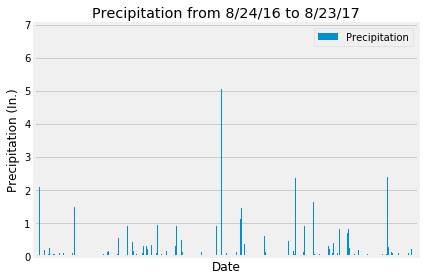

In [130]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

# Perform a query to retrieve the data and precipitation scores, sorted by date
prcp = session.query(Measurement.prcp, Measurement.date).filter(Measurement.date>query_date).order_by\
(Measurement.date).all()
prcp

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp, columns = ['Precipitation', 'Date'])
prcp_df.set_index('Date', inplace=True)


# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot.bar()
plt.xlabel("Date")
plt.title("Precipitation from 8/24/16 to 8/23/17")
plt.xticks([])
plt.ylabel("Precipitation (In.)")
plt.tight_layout()
plt.show()


![precipitation](Images/precipitation.png)

In [ ]:
prcp_df['Precipitation'].max()

In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

![describe](Images/describe.png)

In [177]:
station_first_row = session.query(Measurement).first()
station_first_row.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x128c833c8>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [179]:
# Design a query to show how many stations are available in this dataset?
last_station = session.query(Station.id).order_by(Station.id.desc()).limit(1).all()
last_station

[(9)]

In [174]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station = session.query(Measurement.station).all()
station_df = pd.DataFrame({"Station": station})
station_df["Station"].value_counts().sort_values(ascending=False)


(USC00519281,)    2772
(USC00519397,)    2724
(USC00513117,)    2709
(USC00519523,)    2669
(USC00516128,)    2612
(USC00514830,)    2202
(USC00511918,)    1979
(USC00517948,)    1372
(USC00518838,)     511
Name: Station, dtype: int64

In [194]:
station_count = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [192]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station_temps = session.query(Measurement.station, func.min(Measurement.tobs), \
              func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).limit(1).all()
most_active_station_temps



[('USC00519281', 54.0, 85.0, 71.66378066378067)]

Temperature
Date                   
2016-08-24         77.0
2016-08-25         80.0
2016-08-26         80.0
2016-08-27         75.0
2016-08-28         73.0

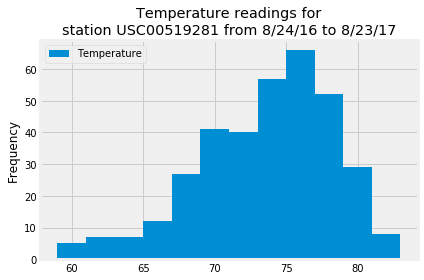

In [256]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC00519281_temps = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == 'USC00519281').\
filter(Measurement.date>query_date).order_by(Measurement.date).all()
USC00519281_temps_df = pd.DataFrame(USC00519281_temps, columns = ['Date', 'Temperature'])
USC00519281_temps_df.set_index('Date', inplace=True)
USC00519281_temps_df.head()

USC00519281_temps_df.plot.hist(bins=12)

plt.title("""Temperature readings for
station USC00519281 from 8/24/16 to 8/23/17""")
plt.tight_layout()
plt.show()


![precipitation](Images/station-histogram.png)

In [264]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all()
last_date[0]

('2017-08-23')

In [325]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-08-16', '2017-08-23'))

[(71.0, 78.73333333333333, 85.0)]


In [326]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-08-16', '2017-08-23'))


[(71.0, 78.73333333333333, 85.0)]


<ErrorbarContainer object of 3 artists>

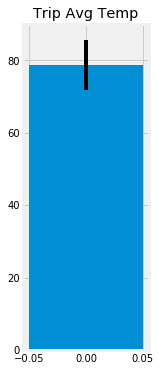

In [328]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots()

yr_avg = calc_temps('2017-08-16', '2017-08-23')[0][1]
yr_min = calc_temps('2017-08-16', '2017-08-23')[0][0]
yr_max = calc_temps('2017-08-16', '2017-08-23')[0][2]
yerr = (yr_max - yr_min)/2

ax.bar(0,yr_avg, .1)
ax.set_title('Trip Avg Temp')
fig.set_figheight(6)
fig.set_figwidth(2)
ax.errorbar(0, yr_avg, yerr= yerr,ecolor='black')



In [329]:
station_first_row = session.query(Measurement).first()
station_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x128c833c8>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [365]:
station_first_row = session.query(Station).first()
station_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1282fe780>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0}

In [375]:
for row in session.query(Station.name, Station.id).all():
    print(row)

('WAIKIKI 717.2, HI US', 1)
('KANEOHE 838.1, HI US', 2)
('KUALOA RANCH HEADQUARTERS 886.9, HI US', 3)
('PEARL CITY, HI US', 4)
('UPPER WAHIAWA 874.3, HI US', 5)
('WAIMANALO EXPERIMENTAL FARM, HI US', 6)
('WAIHEE 837.5, HI US', 7)
('HONOLULU OBSERVATORY 702.2, HI US', 8)
('MANOA LYON ARBO 785.2, HI US', 9)


In [376]:
for row in session.query(Measurement.station, Measurement.id).all():
    print(row)

('USC00519397', 1)
('USC00519397', 2)
('USC00519397', 3)
('USC00519397', 4)
('USC00519397', 5)
('USC00519397', 6)
('USC00519397', 7)
('USC00519397', 8)
('USC00519397', 9)
('USC00519397', 10)
('USC00519397', 11)
('USC00519397', 12)
('USC00519397', 13)
('USC00519397', 14)
('USC00519397', 15)
('USC00519397', 16)
('USC00519397', 17)
('USC00519397', 18)
('USC00519397', 19)
('USC00519397', 20)
('USC00519397', 21)
('USC00519397', 22)
('USC00519397', 23)
('USC00519397', 24)
('USC00519397', 25)
('USC00519397', 26)
('USC00519397', 27)
('USC00519397', 28)
('USC00519397', 29)
('USC00519397', 30)
('USC00519397', 31)
('USC00519397', 32)
('USC00519397', 33)
('USC00519397', 34)
('USC00519397', 35)
('USC00519397', 36)
('USC00519397', 37)
('USC00519397', 38)
('USC00519397', 39)
('USC00519397', 40)
('USC00519397', 41)
('USC00519397', 42)
('USC00519397', 43)
('USC00519397', 44)
('USC00519397', 45)
('USC00519397', 46)
('USC00519397', 47)
('USC00519397', 48)
('USC00519397', 49)
('USC00519397', 50)
('USC0051

('USC00519397', 2713)
('USC00519397', 2714)
('USC00519397', 2715)
('USC00519397', 2716)
('USC00519397', 2717)
('USC00519397', 2718)
('USC00519397', 2719)
('USC00519397', 2720)
('USC00519397', 2721)
('USC00519397', 2722)
('USC00519397', 2723)
('USC00519397', 2724)
('USC00513117', 2725)
('USC00513117', 2726)
('USC00513117', 2727)
('USC00513117', 2728)
('USC00513117', 2729)
('USC00513117', 2730)
('USC00513117', 2731)
('USC00513117', 2732)
('USC00513117', 2733)
('USC00513117', 2734)
('USC00513117', 2735)
('USC00513117', 2736)
('USC00513117', 2737)
('USC00513117', 2738)
('USC00513117', 2739)
('USC00513117', 2740)
('USC00513117', 2741)
('USC00513117', 2742)
('USC00513117', 2743)
('USC00513117', 2744)
('USC00513117', 2745)
('USC00513117', 2746)
('USC00513117', 2747)
('USC00513117', 2748)
('USC00513117', 2749)
('USC00513117', 2750)
('USC00513117', 2751)
('USC00513117', 2752)
('USC00513117', 2753)
('USC00513117', 2754)
('USC00513117', 2755)
('USC00513117', 2756)
('USC00513117', 2757)
('USC00513

('USC00513117', 4769)
('USC00513117', 4770)
('USC00513117', 4771)
('USC00513117', 4772)
('USC00513117', 4773)
('USC00513117', 4774)
('USC00513117', 4775)
('USC00513117', 4776)
('USC00513117', 4777)
('USC00513117', 4778)
('USC00513117', 4779)
('USC00513117', 4780)
('USC00513117', 4781)
('USC00513117', 4782)
('USC00513117', 4783)
('USC00513117', 4784)
('USC00513117', 4785)
('USC00513117', 4786)
('USC00513117', 4787)
('USC00513117', 4788)
('USC00513117', 4789)
('USC00513117', 4790)
('USC00513117', 4791)
('USC00513117', 4792)
('USC00513117', 4793)
('USC00513117', 4794)
('USC00513117', 4795)
('USC00513117', 4796)
('USC00513117', 4797)
('USC00513117', 4798)
('USC00513117', 4799)
('USC00513117', 4800)
('USC00513117', 4801)
('USC00513117', 4802)
('USC00513117', 4803)
('USC00513117', 4804)
('USC00513117', 4805)
('USC00513117', 4806)
('USC00513117', 4807)
('USC00513117', 4808)
('USC00513117', 4809)
('USC00513117', 4810)
('USC00513117', 4811)
('USC00513117', 4812)
('USC00513117', 4813)
('USC00513

('USC00514830', 7269)
('USC00514830', 7270)
('USC00514830', 7271)
('USC00514830', 7272)
('USC00514830', 7273)
('USC00514830', 7274)
('USC00514830', 7275)
('USC00514830', 7276)
('USC00514830', 7277)
('USC00514830', 7278)
('USC00514830', 7279)
('USC00514830', 7280)
('USC00514830', 7281)
('USC00514830', 7282)
('USC00514830', 7283)
('USC00514830', 7284)
('USC00514830', 7285)
('USC00514830', 7286)
('USC00514830', 7287)
('USC00514830', 7288)
('USC00514830', 7289)
('USC00514830', 7290)
('USC00514830', 7291)
('USC00514830', 7292)
('USC00514830', 7293)
('USC00514830', 7294)
('USC00514830', 7295)
('USC00514830', 7296)
('USC00514830', 7297)
('USC00514830', 7298)
('USC00514830', 7299)
('USC00514830', 7300)
('USC00514830', 7301)
('USC00514830', 7302)
('USC00514830', 7303)
('USC00514830', 7304)
('USC00514830', 7305)
('USC00514830', 7306)
('USC00514830', 7307)
('USC00514830', 7308)
('USC00514830', 7309)
('USC00514830', 7310)
('USC00514830', 7311)
('USC00514830', 7312)
('USC00514830', 7313)
('USC00514

('USC00519523', 9768)
('USC00519523', 9769)
('USC00519523', 9770)
('USC00519523', 9771)
('USC00519523', 9772)
('USC00519523', 9773)
('USC00519523', 9774)
('USC00519523', 9775)
('USC00519523', 9776)
('USC00519523', 9777)
('USC00519523', 9778)
('USC00519523', 9779)
('USC00519523', 9780)
('USC00519523', 9781)
('USC00519523', 9782)
('USC00519523', 9783)
('USC00519523', 9784)
('USC00519523', 9785)
('USC00519523', 9786)
('USC00519523', 9787)
('USC00519523', 9788)
('USC00519523', 9789)
('USC00519523', 9790)
('USC00519523', 9791)
('USC00519523', 9792)
('USC00519523', 9793)
('USC00519523', 9794)
('USC00519523', 9795)
('USC00519523', 9796)
('USC00519523', 9797)
('USC00519523', 9798)
('USC00519523', 9799)
('USC00519523', 9800)
('USC00519523', 9801)
('USC00519523', 9802)
('USC00519523', 9803)
('USC00519523', 9804)
('USC00519523', 9805)
('USC00519523', 9806)
('USC00519523', 9807)
('USC00519523', 9808)
('USC00519523', 9809)
('USC00519523', 9810)
('USC00519523', 9811)
('USC00519523', 9812)
('USC00519

('USC00519281', 12768)
('USC00519281', 12769)
('USC00519281', 12770)
('USC00519281', 12771)
('USC00519281', 12772)
('USC00519281', 12773)
('USC00519281', 12774)
('USC00519281', 12775)
('USC00519281', 12776)
('USC00519281', 12777)
('USC00519281', 12778)
('USC00519281', 12779)
('USC00519281', 12780)
('USC00519281', 12781)
('USC00519281', 12782)
('USC00519281', 12783)
('USC00519281', 12784)
('USC00519281', 12785)
('USC00519281', 12786)
('USC00519281', 12787)
('USC00519281', 12788)
('USC00519281', 12789)
('USC00519281', 12790)
('USC00519281', 12791)
('USC00519281', 12792)
('USC00519281', 12793)
('USC00519281', 12794)
('USC00519281', 12795)
('USC00519281', 12796)
('USC00519281', 12797)
('USC00519281', 12798)
('USC00519281', 12799)
('USC00519281', 12800)
('USC00519281', 12801)
('USC00519281', 12802)
('USC00519281', 12803)
('USC00519281', 12804)
('USC00519281', 12805)
('USC00519281', 12806)
('USC00519281', 12807)
('USC00519281', 12808)
('USC00519281', 12809)
('USC00519281', 12810)
('USC005192

('USC00511918', 15767)
('USC00511918', 15768)
('USC00511918', 15769)
('USC00511918', 15770)
('USC00511918', 15771)
('USC00511918', 15772)
('USC00511918', 15773)
('USC00511918', 15774)
('USC00511918', 15775)
('USC00511918', 15776)
('USC00511918', 15777)
('USC00511918', 15778)
('USC00511918', 15779)
('USC00511918', 15780)
('USC00511918', 15781)
('USC00511918', 15782)
('USC00511918', 15783)
('USC00511918', 15784)
('USC00511918', 15785)
('USC00511918', 15786)
('USC00511918', 15787)
('USC00511918', 15788)
('USC00511918', 15789)
('USC00511918', 15790)
('USC00511918', 15791)
('USC00511918', 15792)
('USC00511918', 15793)
('USC00511918', 15794)
('USC00511918', 15795)
('USC00511918', 15796)
('USC00511918', 15797)
('USC00511918', 15798)
('USC00511918', 15799)
('USC00511918', 15800)
('USC00511918', 15801)
('USC00511918', 15802)
('USC00511918', 15803)
('USC00511918', 15804)
('USC00511918', 15805)
('USC00511918', 15806)
('USC00511918', 15807)
('USC00511918', 15808)
('USC00511918', 15809)
('USC005119

('USC00516128', 18566)
('USC00516128', 18567)
('USC00516128', 18568)
('USC00516128', 18569)
('USC00516128', 18570)
('USC00516128', 18571)
('USC00516128', 18572)
('USC00516128', 18573)
('USC00516128', 18574)
('USC00516128', 18575)
('USC00516128', 18576)
('USC00516128', 18577)
('USC00516128', 18578)
('USC00516128', 18579)
('USC00516128', 18580)
('USC00516128', 18581)
('USC00516128', 18582)
('USC00516128', 18583)
('USC00516128', 18584)
('USC00516128', 18585)
('USC00516128', 18586)
('USC00516128', 18587)
('USC00516128', 18588)
('USC00516128', 18589)
('USC00516128', 18590)
('USC00516128', 18591)
('USC00516128', 18592)
('USC00516128', 18593)
('USC00516128', 18594)
('USC00516128', 18595)
('USC00516128', 18596)
('USC00516128', 18597)
('USC00516128', 18598)
('USC00516128', 18599)
('USC00516128', 18600)
('USC00516128', 18601)
('USC00516128', 18602)
('USC00516128', 18603)
('USC00516128', 18604)
('USC00516128', 18605)
('USC00516128', 18606)
('USC00516128', 18607)
('USC00516128', 18608)
('USC005161

In [383]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Measurement.station, Station.name,\
              Station.latitude, Station.longitude, Station.elevation).\
filter(Measurement.date >= "2016-08-16").filter(Measurement.date <= "2016-08-23").\
filter(Measurement.station == Station.station).\
group_by(Measurement.station).order_by(func.sum(Measurement.prcp)).all()

# Not all 9 stations had recordings or not all 9 stations existed


[('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


tmin       tavg  tmax
date                             
2018-01-01  62.0  69.153846  77.0
2018-01-02  60.0  69.396226  77.0
2018-01-03  62.0  68.909091  77.0
2018-01-04  58.0  70.000000  76.0
2018-01-05  56.0  67.964286  76.0

<IPython.core.display.Javascript object>


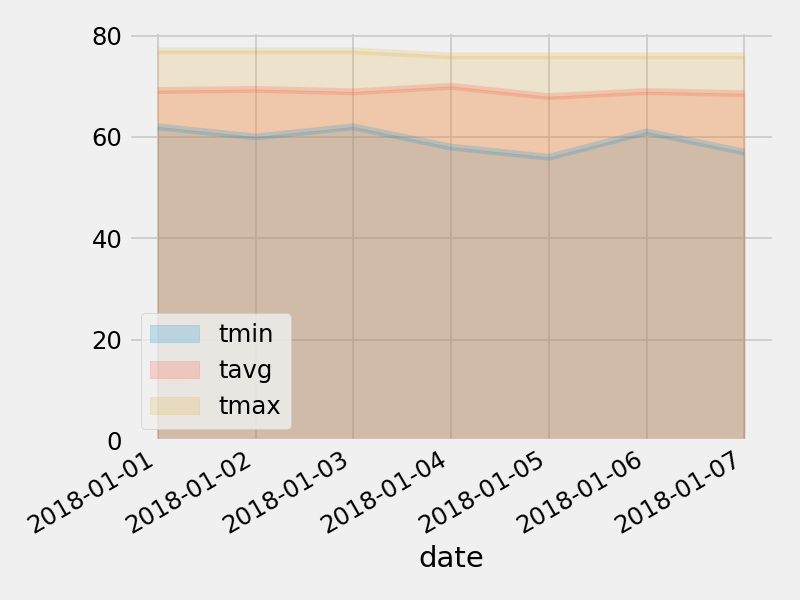

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
